In [1]:
!pip install pyarrow
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix,dok_matrix
from numba import jit
import pyarrow as pa

In [116]:
with open('pages.arrow','rb') as f:
    pages = pa.default_serialization_context().deserialize(f.read())

with open('revisions.arrow','rb') as f:
    revisions = pa.default_serialization_context().deserialize(f.read())

In [3]:
revisions

,page,user,count
0,1,2,6
1,1,4,28
2,1,5,13
3,1,7,25
4,1,8,37
...,...,...,...
44568346,1166588,292,1
44568347,1166589,292,1
44568348,1166590,292,1
44568349,1166591,10398,1


In [4]:
raw_counts = csr_matrix((revisions['count'], (revisions['page'],revisions['user'])))

In [5]:
raw_counts

<1166593x9975546 sparse matrix of type '<class 'numpy.int32'>'
	with 44568351 stored elements in Compressed Sparse Row format>

In [6]:
ones_col = lambda m: csr_matrix(np.ones((m.shape[1],1)))
ones_row = lambda m: csr_matrix(np.ones((1,m.shape[0])))

In [7]:
edits_per_page = raw_counts * ones_col(raw_counts)
users_per_page = raw_counts.power(0.0) * ones_col(raw_counts)
total_pages = edits_per_page.power(0.0).sum()

In [8]:
users_per_page[1,0]

10645.0

In [9]:
edits_per_user = ones_row(raw_counts) * raw_counts
pages_per_user = ones_row(raw_counts) * raw_counts.power(0.0)

In [10]:
pages_per_user[0,9]

290564.0

In [11]:
pd.Series(np.sort((total_pages * pages_per_user.data ** -1.0))).plot(loglog=True, grid=True)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


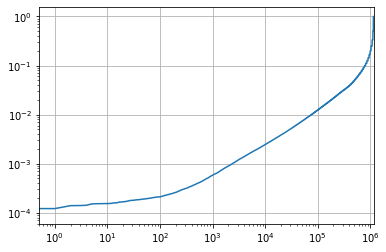

In [12]:
pd.Series(np.sort((users_per_page.data ** -1.0))).plot(loglog=True, grid=True)

In [13]:
idf_bell_curve_weights = pages_per_user.copy()
idf_bell_curve_weights.data = np.exp(((idf_bell_curve_weights.data - 2048) ** 2) / -7000000)

In [14]:
weighted_counts = raw_counts.log1p().multiply(pages_per_user.power(-1.0)).multiply(idf_bell_curve_weights)

In [15]:
inv_page_magnitudes = (weighted_counts.power(2) * ones_col(weighted_counts)).power(-0.5).transpose().toarray()[0]


In [16]:
topThreshold = 20

In [17]:
weighted_counts = weighted_counts.astype(np.float32)
weighted_counts.eliminate_zeros()
weighted_countsT = weighted_counts.transpose().tocsr()

In [18]:
#similarities = dok_matrix((weighted_counts.shape[0],weighted_counts.shape[0])).astype(np.float32)
topSimilarPages = np.zeros(shape=(weighted_counts.shape[0], topThreshold)).astype(np.int32)
topSimilarities = np.zeros(shape=(weighted_counts.shape[0], topThreshold)).astype(np.float32)


In [19]:
[raw_counts.nnz, weighted_counts.nnz]

[44568351, 33367930]

In [20]:
topSimilarPages.shape

(1166593, 20)

In [21]:
row_storage = np.zeros(shape=(1, weighted_counts.shape[0]), dtype=np.float32)
related = np.zeros(shape=weighted_counts.shape[0], dtype=np.float32)
topThresholdIdxs = np.arange(topThreshold) - topThreshold

def do_row(i):
    row=weighted_counts[i]
    related = (row * weighted_countsT).toarray(out=row_storage)[0]
    related[i] = 0
    related *= inv_page_magnitudes
    topRelatedIdxs = np.argpartition(related, topThresholdIdxs)[-topThreshold:]
    topSimilarPages[i] = topRelatedIdxs
    topSimilarities[i] = related[topRelatedIdxs]

for i in range(weighted_counts.shape[0]):
    do_row(i)
    if i % 1000 == 0:
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1164000
1165000
1166000


In [22]:
topSimilarities

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.41066045e-01, 1.43484712e-01, 1.46386206e-01, ...,
        2.53651947e-01, 3.01380396e-01, 4.42515939e-01],
       [1.04604065e-01, 1.08773679e-01, 1.09063648e-01, ...,
        2.24040613e-01, 3.20141345e-01, 3.95223558e-01],
       ...,
       [2.49665391e-08, 2.49665391e-08, 2.49665391e-08, ...,
        2.49665391e-08, 2.49665391e-08, 2.49665391e-08],
       [1.35049049e-03, 1.35049049e-03, 1.35049049e-03, ...,
        1.35049049e-03, 1.35049049e-03, 1.35049049e-03],
       [3.50221177e-04, 3.98586126e-04, 5.74024278e-04, ...,
        9.02729295e-03, 9.07708146e-03, 9.07708332e-03]], dtype=float32)

In [23]:
buckets = 256
topSimilaritiesPositive = topSimilarities.flatten()[topSimilarities.flatten() > 0]
bins = np.array([np.percentile(topSimilaritiesPositive, 100.0 * i / buckets) for i in range(buckets)])
bins[0] = 0
print(bins)

[0.00000000e+00 2.38798502e-18 2.89095422e-17 1.25208738e-15
 1.98451159e-15 2.50417477e-15 7.57043191e-13 2.19482529e-10
 1.26219328e-08 2.27156871e-08 1.44960637e-07 7.07395941e-07
 1.30314413e-06 1.59371382e-06 3.72560203e-06 7.84585882e-06
 1.10237552e-05 1.78665878e-05 2.73833484e-05 3.58829275e-05
 3.95061870e-05 4.98237023e-05 6.56145130e-05 7.21211109e-05
 8.28650182e-05 9.99964605e-05 1.05154249e-04 1.13797440e-04
 1.20935889e-04 1.37084877e-04 1.44290854e-04 1.58981056e-04
 1.69795632e-04 1.84999590e-04 2.00797903e-04 2.18014800e-04
 2.35051586e-04 2.46461452e-04 2.62491667e-04 2.73289770e-04
 2.88234471e-04 3.02377826e-04 3.14185076e-04 3.27494985e-04
 3.46459565e-04 3.60392180e-04 3.74027062e-04 3.84784827e-04
 3.98301985e-04 4.10286419e-04 4.21457080e-04 4.36924107e-04
 4.49422398e-04 4.66399943e-04 4.79195849e-04 4.87894547e-04
 5.03133808e-04 5.17561391e-04 5.32037579e-04 5.41524496e-04
 5.55256964e-04 5.65066352e-04 5.79699525e-04 5.94187528e-04
 6.09175360e-04 6.219231

In [24]:
(-np.log(bins) / np.log(1.1)).clip(1,255).astype(np.uint8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([255, 255, 255, 255, 255, 255, 255, 233, 190, 184, 165, 148, 142,
       140, 131, 123, 119, 114, 110, 107, 106, 103, 101, 100,  98,  96,
        96,  95,  94,  93,  92,  91,  91,  90,  89,  88,  87,  87,  86,
        86,  85,  85,  84,  84,  83,  83,  82,  82,  82,  81,  81,  81,
        80,  80,  80,  80,  79,  79,  79,  78,  78,  78,  78,  77,  77,
        77,  77,  77,  76,  76,  76,  75,  75,  75,  75,  75,  74,  74,
        74,  74,  74,  73,  73,  73,  73,  73,  72,  72,  72,  72,  72,
        71,  71,  71,  71,  71,  70,  70,  70,  70,  70,  69,  69,  69,
        69,  69,  69,  68,  68,  68,  68,  68,  68,  67,  67,  67,  67,
        67,  67,  66,  66,  66,  66,  66,  66,  65,  65,  65,  65,  65,
        65,  64,  64,  64,  64,  64,  64,  63,  63,  63,  63,  63,  62,
        62,  62,  62,  62,  62,  61,  61,  61,  61,  61,  61,  60,  60,
        60,  60,  60,  59,  59,  59,  59,  59,  58,  58,  58,  58,  58,
        58,  57,  57,  57,  57,  56,  56,  56,  56,  56,  55,  5

In [25]:
topSimilaritiesQ = bins[np.clip(np.digitize(topSimilarities, bins, right=True),0,buckets-1)]
topSimilaritiesQ

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.88950395e-01, 1.88950395e-01, 1.88950395e-01, ...,
        1.88950395e-01, 1.88950395e-01, 1.88950395e-01],
       [1.27128437e-01, 1.27128437e-01, 1.27128437e-01, ...,
        1.88950395e-01, 1.88950395e-01, 1.88950395e-01],
       ...,
       [1.44960637e-07, 1.44960637e-07, 1.44960637e-07, ...,
        1.44960637e-07, 1.44960637e-07, 1.44960637e-07],
       [1.35122740e-03, 1.35122740e-03, 1.35122740e-03, ...,
        1.35122740e-03, 1.35122740e-03, 1.35122740e-03],
       [3.60392180e-04, 4.10286419e-04, 5.79699525e-04, ...,
        9.07972548e-03, 9.07972548e-03, 9.07972548e-03]])

In [26]:
topSimilaritiesLog = np.where(topSimilarities == 0, 0, (-np.log(topSimilarities)/np.log(1.1)).clip(1,256).astype(np.uint8))
topSimilaritiesLog

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([[  0,   0,   0, ...,   0,   0,   0],
       [ 20,  20,  20, ...,  14,  12,   8],
       [ 23,  23,  23, ...,  15,  11,   9],
       ...,
       [183, 183, 183, ..., 183, 183, 183],
       [ 69,  69,  69, ...,  69,  69,  69],
       [ 83,  82,  78, ...,  49,  49,  49]], dtype=uint8)

In [27]:
topSimilarPagesZ = np.where(topSimilaritiesLog == 0, 0, topSimilarPages)
topSimilarPagesZ

array([[      0,       0,       0, ...,       0,       0,       0],
       [ 372557,       5,  519911, ...,  515563,  895779,  534809],
       [ 640516,  803405,  542541, ...,      18,  527631,  844355],
       ...,
       [1166587, 1158055, 1158049, ..., 1166561, 1166560, 1158076],
       [1150555, 1152732, 1165131, ..., 1162080, 1162081, 1138851],
       [ 390092,  408266,  448188, ...,  698176, 1031545, 1001866]],
      dtype=int32)

In [28]:
simDF = pd.DataFrame(topSimilaritiesLog, columns=[f"sim{-i}" for i in topThresholdIdxs])
pageDF = pd.DataFrame(topSimilarPagesZ, columns=[f"page{-i}" for i in topThresholdIdxs])
tops = simDF.merge(pageDF, left_index=True, right_index=True)
tops

,sim20,sim19,sim18,sim17,sim16,sim15,sim14,sim13,sim12,sim11,...,page10,page9,page8,page7,page6,page5,page4,page3,page2,page1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,20,20,19,19,19,19,18,18,17,...,742578,769406,645739,556479,379026,263291,763547,515563,895779,534809
2,23,23,23,23,23,22,22,22,22,21,...,307539,863997,757570,462959,710337,598969,916615,18,527631,844355
3,25,25,25,24,24,22,22,22,21,21,...,361559,291671,269447,49,684807,876105,113498,551225,669207,700121
4,25,25,24,24,24,24,24,23,23,22,...,370245,309652,350676,560866,169137,493339,758244,428529,368563,515063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166588,183,183,183,183,183,183,183,183,183,183,...,1166568,1166567,1166566,1166565,1158075,1166563,1166562,1166561,1166560,1158076
1166589,183,183,183,183,183,183,183,183,183,183,...,1166568,1166567,1166566,1166565,1158075,1166563,1166562,1166561,1166560,1158076
1166590,183,183,183,183,183,183,183,183,183,183,...,1166568,1166567,1166566,1166565,1158075,1166563,1166562,1166561,1166560,1158076
1166591,69,69,69,69,69,69,69,69,69,69,...,1153686,1112640,1136896,1157605,1142344,1152525,1162331,1162080,1162081,1138851


In [29]:
with open(f"tops{topThreshold}.arrow", "wb") as f:
    f.write(pa.default_serialization_context().serialize(tops).to_buffer())

In [30]:
topsPacked = pd.DataFrame(topSimilarPagesZ * 256 + topSimilaritiesLog, columns=[f'ps{-i}' for i in topThresholdIdxs])
with open(f"topsPacked{topThreshold}.arrow","wb") as f:
    f.write(pa.default_serialization_context().serialize(topsPacked).to_buffer())
topsPacked

,ps20,ps19,ps18,ps17,ps16,ps15,ps14,ps13,ps12,ps11,ps10,ps9,ps8,ps7,ps6,ps5,ps4,ps3,ps2,ps1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,95374612,1300,133097236,139787539,172839187,103090963,118569235,201028370,58577682,68808721,190099985,196967953,165309201,142458641,97030673,67402512,195468048,131984142,229319436,136911112
2,163972119,205671703,138890519,91400727,263639319,46209558,103375126,41006358,52739862,150712597,78730004,221183251,193937939,118517523,181846290,153336081,234653457,4623,135073547,216154889
3,133048089,77565209,281,110738968,9938200,142398742,73254934,45007126,118711573,163165717,92559123,74667794,68978449,12561,175310608,224282896,29055502,141113611,171317002,179230986
4,183987993,49689,61457432,190470168,71595032,43679000,37834264,113192983,65776151,173818390,94782742,79270933,89773077,143581715,43299089,126294801,194110481,109703440,94352142,131856140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166588,298646455,296462263,296460727,252293815,296459703,293449911,293450423,293450935,293452471,298641847,298641591,298641335,298641079,298640823,296467383,298640311,298640055,298639799,298639543,296467639
1166589,298646455,296462263,296460727,252293815,296459703,293449911,293450423,293450935,293452471,298641847,298641591,298641335,298641079,298640823,296467383,298640311,298640055,298639799,298639543,296467639
1166590,298646455,296462263,296460727,252293815,296459703,293449911,293450423,293450935,293452471,298641847,298641591,298641335,298641079,298640823,296467383,298640311,298640055,298639799,298639543,296467639
1166591,294542149,295099461,298273605,285980997,292521285,280724805,298534213,291451973,294162501,297557061,295343685,284835909,291045445,296346949,292440133,295046469,297556805,297492549,297492805,291545925


In [31]:
data = [pa.array(topsPacked[c]) for c in topsPacked.columns]
batch = pa.RecordBatch.from_arrays(data, topsPacked.columns)
sink = pa.BufferOutputStream()
writer = pa.RecordBatchStreamWriter(sink, batch.schema)
writer.write_batch(batch)
writer.close()
with open('topsPacked20.noindex.arrow', 'wb') as f:
    f.write(sink.getvalue())

In [140]:
radpages = pages.copy()
radpages['lat'] = np.deg2rad(radpages['lat'])
radpages['lng'] = np.deg2rad(radpages['lng'])
radpages.loc[0] = None
radpages

,title,lat,lng
id,,,
1,United States,0.698132,-1.745329
2,India,0.366519,1.361357
3,United Kingdom,0.959931,-0.052360
4,New York City,0.709668,-1.290566
5,Canada,1.047198,-1.658063
...,...,...,...
1166589,Hebrig railway station,0.826622,0.165195
1166590,Gais railway station,0.826607,0.164953
1166591,Zedi Bakhvi,0.732088,0.735273


In [119]:
def distance(s_lat, s_lng, e_lat, e_lng):
    earth_radius = 6373.0
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    return 2 * earth_radius * np.arcsin(np.sqrt(d))

In [ ]:
topFarSimilarPages = np.zeros(shape=(weighted_counts.shape[0], topThreshold)).astype(np.int32)
topFarSimilarities = np.zeros(shape=(weighted_counts.shape[0], topThreshold)).astype(np.float32)
minKilometers = 500

def do_far_row(i):
    similar = weighted_counts[i] * weighted_countsT
    simpages = radpages.loc[similar.indices]
    near = distance(simpages['lat'],simpages['lng'],radpages.loc[i]['lat'],radpages.loc[i]['lng']) < minKilometers
    similar.data[near] = 0
    related = similar.toarray(out=row_storage)[0]
    related[i] = 0
    related *= inv_page_magnitudes
    topRelatedIdxs = np.argpartition(related, topThresholdIdxs)[-topThreshold:]
    topFarSimilarPages[i] = topRelatedIdxs
    topFarSimilarities[i] = related[topRelatedIdxs]

for i in range(weighted_counts.shape[0]):
    do_far_row(i)
    if i % 1000 == 0:
        print(i)


In [146]:
topFarSimilaritiesLog = np.where(topFarSimilarities == 0, 0, (-np.log(topFarSimilarities)/np.log(1.1)).clip(1,256).astype(np.uint8))
topFarSimilaritiesLog

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([[  0,   0,   0, ...,   0,   0,   0],
       [ 20,  20,  20, ...,  14,  12,   8],
       [ 23,  23,  23, ...,  15,  11,   9],
       ...,
       [255, 255, 255, ..., 209, 183, 183],
       [133, 133, 133, ...,  80,  69,  69],
       [ 83,  82,  78, ...,  49,  49,  49]], dtype=uint8)

In [147]:
topFarSimilarPagesZ = np.where(topFarSimilaritiesLog == 0, 0, topFarSimilarPages)
topFarSimilarPagesZ

array([[      0,       0,       0, ...,       0,       0,       0],
       [ 335373,  372557,       5, ...,  515563,  895779,  534809],
       [ 640516,  803405,  542541, ...,      18,  527631,  844355],
       ...,
       [ 796370,  580640,  999249, ...,  796996, 1116802,  997007],
       [  37011,   78806,  382960, ...,  671645, 1112640, 1138851],
       [ 390092,  408266,  448188, ...,  698176, 1031545, 1001866]],
      dtype=int32)

In [148]:
topsFarPacked = pd.DataFrame(topFarSimilarPagesZ * 256 + topFarSimilaritiesLog, columns=[f'ps{-i}' for i in topThresholdIdxs])
topsFarPacked

,ps20,ps19,ps18,ps17,ps16,ps15,ps14,ps13,ps12,ps11,ps10,ps9,ps8,ps7,ps6,ps5,ps4,ps3,ps2,ps1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,85855508,95374612,1300,133097236,139787539,172839187,103090963,118569235,201028370,58577682,68808721,190099985,196967953,142458641,97030673,67402512,195468048,131984142,229319436,136911112
2,163972119,205671703,138890519,91400727,263639319,46209558,103375126,41006358,52739862,150712597,78730004,221183251,193937939,118517523,181846290,153336081,234653457,4623,135073547,216154889
3,45516316,101779740,115659548,243279644,68987931,4260891,92047131,15853338,133048089,77565209,281,110738968,73254934,118711573,74667794,68978449,175310608,224282896,141113611,171317002
4,165174299,265905434,61148698,149764890,15898,183987993,61457432,190470168,43679000,113192983,173818390,94782742,79270933,143581715,43299089,126294801,194110481,109703440,94352142,131856140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166588,203870975,148644095,255807999,188134399,178437887,247837439,182233343,216878591,198086143,239723519,217797630,232310013,239508219,281338106,236521463,217310953,188169447,204031185,285901495,255233975
1166589,203870975,148644095,255807999,188134399,178437887,247837439,182233343,216878591,198086143,239723519,217797630,232310013,239508219,281338106,236521463,217310953,188169447,204031185,285901495,255233975
1166590,203870975,148644095,255807999,188134399,178437887,247837439,182233343,216878591,239723519,198086143,217797630,232310013,239508219,281338106,236521463,217310953,188169447,204031185,285901495,255233975
1166591,9474949,20174469,98037893,38049925,49873796,115968132,60801156,36544642,79052673,198380160,62961534,271199858,238061423,57865069,69908584,57094760,247690074,171941200,284835909,291545925


In [149]:
data = [pa.array(topsFarPacked[c]) for c in topsFarPacked.columns]
batch = pa.RecordBatch.from_arrays(data, topsFarPacked.columns)
sink = pa.BufferOutputStream()
writer = pa.RecordBatchStreamWriter(sink, batch.schema)
writer.write_batch(batch)
writer.close()
with open('topsFarPacked20.noindex.arrow', 'wb') as f:
    f.write(sink.getvalue())